## Init

In [365]:
import datetime
import glob
import os
import pandas as pd
import seaborn
import subprocess

from graphviz import Digraph
from math import log2

PCAP_DIR = "../cap/"

In [366]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/glancioni/.local/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['log2', 'info', 'entropy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [367]:
def read_pcap(filename, fields=[], display_filter="", 
              timeseries=False, strict=False):
    """ Read PCAP file into Pandas DataFrame object. 
    Uses tshark command-line tool from Wireshark.

    filename:       Name or full path of the PCAP file to read
    fields:         List of fields to include as columns
    display_filter: Additional filter to restrict frames
    strict:         Only include frames that contain all given fields 
                    (Default: false)
    timeseries:     Create DatetimeIndex from frame.time_epoch 
                    (Default: false)

    Syntax for fields and display_filter is specified in
    Wireshark's Display Filter Reference:
 
      http://www.wireshark.org/docs/dfref/
    """
    if timeseries:
        fields = ["frame.time_epoch"] + fields
    fieldspec = " ".join("-e %s" % f for f in fields)

    display_filters = fields if strict else []
    if display_filter:
        display_filters.append(display_filter)
    filterspec = "-Y '%s'" % " and ".join(f for f in display_filters)

    options = "-r %s -n -T fields -Eheader=y" % filename
    cmd = "tshark %s %s %s" % (options, filterspec, fieldspec)
    proc = subprocess.Popen(cmd, shell = True, 
                                 stdout=subprocess.PIPE,
                                 stderr=subprocess.PIPE)
    
    try:
        if timeseries:
            df = pd.read_table(proc.stdout, 
                            index_col = "frame.time_epoch", 
                            parse_dates=True, 
                            date_parser=datetime.datetime.fromtimestamp)
        else:
            df = pd.read_table(proc.stdout)
    except pd.io.common.EmptyDataError as e:
        raise Exception(proc.stderr.read(1000).decode('utf-8'))
    
    return df

In [368]:
def path_to_filename(path):
    name = os.path.basename(path)
    return os.path.splitext(name)[0]

In [369]:
def load_all(fields=[], display_filter="", 
              timeseries=False, strict=False):
    files = glob.iglob(PCAP_DIR+"*.pcap")
    return {path_to_filename(file): read_pcap(file, fields, display_filter, timeseries, strict)
            for file in files}

In [370]:
def decode_ARP_opcodes(df):
    return df["arp.opcode"].map(lambda c: "who-has" if c==1 else "is-at")

## Cargar los PCAPs

In [371]:
tables = load_all(["_ws.col.Protocol", "_ws.col.Info", "frame.number", "frame.time_epoch", "arp.opcode",
                   "arp.src.hw_mac", "arp.src.proto_ipv4", "arp.dst.hw_mac", "arp.dst.proto_ipv4", "eth.dst"])

In [372]:
print(list(tables.keys()))

['EXACTAS-UBA', 'RED-domestica']


In [373]:
t = tables["EXACTAS-UBA"]
t["arp.op"] = decode_ARP_opcodes(t)

t_is_arp = t["_ws.col.Protocol"] == "ARP"
t_arp = t[t_is_arp]

In [374]:
t_arp

,_ws.col.Protocol,_ws.col.Info,frame.number,frame.time_epoch,arp.opcode,arp.src.hw_mac,arp.src.proto_ipv4,arp.dst.hw_mac,arp.dst.proto_ipv4,eth.dst,arp.op
191,ARP,Gratuitous ARP for 10.210.144.240 (Request),192,1.493931e+09,1.0,b4:52:7e:e9:fc:18,10.210.144.240,00:00:00:00:00:00,10.210.144.240,ff:ff:ff:ff:ff:ff,who-has
1367,ARP,Gratuitous ARP for 10.210.71.243 (Request),1368,1.493931e+09,1.0,24:5b:a7:3c:f8:2f,10.210.71.243,00:00:00:00:00:00,10.210.71.243,ff:ff:ff:ff:ff:ff,who-has
1370,ARP,Gratuitous ARP for 10.210.71.243 (Request),1371,1.493931e+09,1.0,24:5b:a7:3c:f8:2f,10.210.71.243,00:00:00:00:00:00,10.210.71.243,ff:ff:ff:ff:ff:ff,who-has
1384,ARP,Gratuitous ARP for 10.210.71.243 (Request),1385,1.493931e+09,1.0,24:5b:a7:3c:f8:2f,10.210.71.243,00:00:00:00:00:00,10.210.71.243,ff:ff:ff:ff:ff:ff,who-has
1831,ARP,Gratuitous ARP for 10.210.80.65 (Request),1832,1.493931e+09,1.0,6c:8d:c1:3e:45:45,10.210.80.65,00:00:00:00:00:00,10.210.80.65,ff:ff:ff:ff:ff:ff,who-has
1832,ARP,Gratuitous ARP for 10.210.80.65 (Request),1833,1.493931e+09,1.0,6c:8d:c1:3e:45:45,10.210.80.65,00:00:00:00:00:00,10.210.80.65,ff:ff:ff:ff:ff:ff,who-has
1833,ARP,Gratuitous ARP for 10.210.80.65 (Request),1834,1.493931e+09,1.0,6c:8d:c1:3e:45:45,10.210.80.65,00:00:00:00:00:00,10.210.80.65,ff:ff:ff:ff:ff:ff,who-has
1959,ARP,Gratuitous ARP for 10.210.174.129 (Request),1960,1.493931e+09,1.0,58:40:4e:5a:be:cc,10.210.174.129,00:00:00:00:00:00,10.210.174.129,ff:ff:ff:ff:ff:ff,who-has
1996,ARP,Gratuitous ARP for 10.210.174.129 (Request),1997,1.493931e+09,1.0,58:40:4e:5a:be:cc,10.210.174.129,00:00:00:00:00:00,10.210.174.129,ff:ff:ff:ff:ff:ff,who-has
2395,ARP,Gratuitous ARP for 10.210.174.129 (Request),2396,1.493931e+09,1.0,58:40:4e:5a:be:cc,10.210.174.129,00:00:00:00:00:00,10.210.174.129,ff:ff:ff:ff:ff:ff,who-has


In [375]:
t_arp.groupby(t_arp["arp.op"])["arp.op"].count()

arp.op
who-has    134
Name: arp.op, dtype: int64

## Gráficos fuente S

33648 unicasts
401 broadcasts
34049 en total

69834 unicasts
289 broadcasts
70123 en total



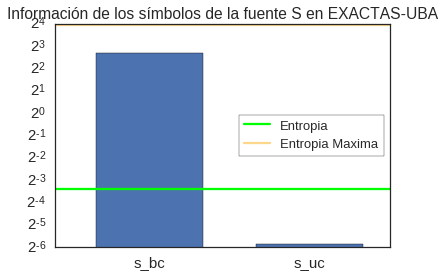

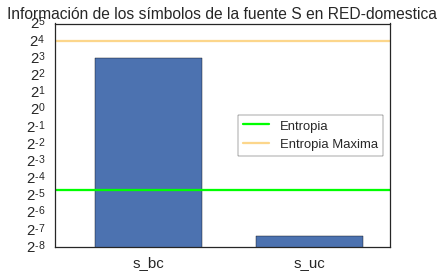

In [376]:
# contar cantidad de paquetes broadcast/unicast

for file in tables.keys():
    t = tables[file]
    broadcasts = t["eth.dst"] == 'ff:ff:ff:ff:ff:ff'

    cantidad_broadcasts = t[broadcasts].shape[0]
    total = t.shape[0]
    cantidad_unicasts = total - cantidad_broadcasts

    print("{:d} unicasts".format(cantidad_unicasts)) 
    print("{:d} broadcasts".format(cantidad_broadcasts)) 
    print("{:d} en total".format(total)) 
    print()

    # cuentitas

    proba_broadcast = cantidad_broadcasts/total
    proba_unicast = cantidad_unicasts/total

    info_broadcast = 0 if proba_broadcast == 0 else -log2(proba_broadcast)
    info_unicast = 0 if proba_unicast == 0 else -log2(proba_unicast)

    entropia = proba_unicast*info_unicast + proba_broadcast*info_broadcast
    entropia_maxima = log2(total)

    # imprimir barras

    fig, ax = plt.subplots()

    bar1 = ax.bar([0.3, 1.5], [info_broadcast, info_unicast], 0.8)
    entropy=ax.axhline(y=entropia, label='Entropia', color='#00ff00')
    entropy_max=ax.axhline(y=entropia_maxima, label='Entropia Maxima', color='#fcd68b')

    plt.legend(handles=[entropy, entropy_max], loc=5, frameon=True)
    ax.set_xticks([0.7, 1.9])
    ax.set_xticklabels(['s_bc', 's_uc'])
    plt.tick_params(axis='both', labelsize=15)
    ax.set_yscale('log', basey=2)

    titulo = "Información de los símbolos de la fuente S en " + file
    ax.set_title(titulo)
    path_file = "../img/barras-" + file + ".pdf"
    plt.savefig(path_file)


## Grafo de los paquetes who-has

In [377]:
# http://graphviz.readthedocs.io/en/stable/manual.html

for file in tables.keys():
    t = tables[file]
    t["arp.op"] = decode_ARP_opcodes(t)
    t_is_arp = t["_ws.col.Protocol"] == "ARP"
    t_arp = t[t_is_arp]

    grafo = Digraph(comment= "Grafo de los paquetes who-has")
    grafo.attr(size='20,2000')
    grafo.node_attr.update(color='lightblue2', style='filled')

    # ejemplo:
    # grafo.node('A', 'King Arthur')
    # grafo.node('B', 'Prince John')
    # grafo.edge('A', 'B')

    requests_filas = t_arp["arp.op"] == "who-has"
    t_requests = t_arp[requests_filas]

    nodos = set()
    aristas = set()
    for index, fila in t_requests.iterrows():
        nodos.add(fila["arp.dst.proto_ipv4"])
        nodos.add(fila["arp.src.proto_ipv4"])
        aristas.add((fila["arp.src.proto_ipv4"], fila["arp.dst.proto_ipv4"]))

    for nodo in nodos:
        grafo.node(nodo, nodo)

    for arista in aristas:
        grafo.edge(arista[0], arista[1])

    grafo_dir = '../img/red-' + file
    grafo.render(grafo_dir, view=True)

## Gráficos de información

4.96312873701


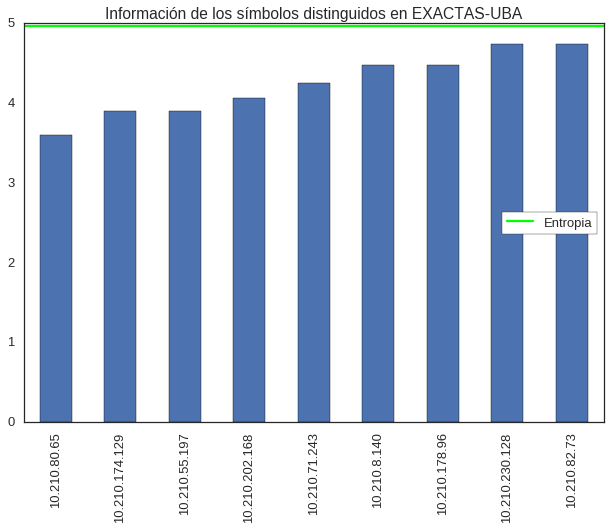

0.812607240563


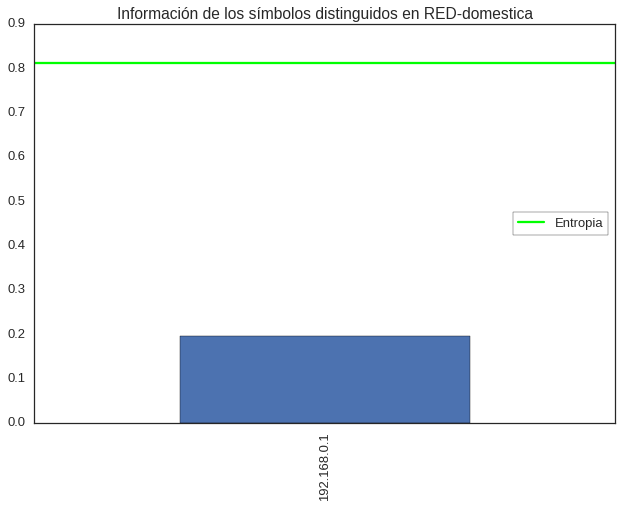

In [378]:
for file in tables.keys():
    
    # buscar la información de los distinguidos
    t = tables[file]
    t["arp.op"] = decode_ARP_opcodes(t)
    t_is_arp = t["_ws.col.Protocol"] == "ARP"
    t_arp = t[t_is_arp]
    
    requests_filas = t_arp["arp.op"] == "who-has"
    t_requests = t_arp[requests_filas]   
    fuente_apariciones = {}
    
    for index, fila in t_requests.iterrows():
        buscado = fila["arp.dst.proto_ipv4"]
        if buscado not in fuente_apariciones:
            fuente_apariciones[buscado] = t_requests[(t_requests["arp.dst.proto_ipv4"] == buscado)].shape[0]
    
    total = t_requests.shape[0]
    fuente_probabilidades = {s: fuente_apariciones[s] / total for s in fuente_apariciones}
    fuente_informacion = {s: -log2(fuente_probabilidades[s]) for s in fuente_probabilidades}

    fuente_entropia = sum([fuente_probabilidades[s]*fuente_informacion[s] for s in fuente_apariciones])
    nodos = []
    info = []
    for s in fuente_informacion:
        if fuente_informacion[s] < fuente_entropia:
            nodos.append(s)
            info.append(fuente_informacion[s])
    
    print(fuente_entropia)
    # graficar
    seaborn.set(style="white", context="talk")
    
    data = {"Información" : pd.Series(info, index=nodos)}
    df = pd.DataFrame(data)
    df = df.sort_values("Información")
    titulo = "Información de los símbolos distinguidos en " + file
    ax = df.plot(kind='bar', title=titulo)
    entropy = ax.axhline(fuente_entropia, label='Entropia', color='#00ff00')

    plt.legend(handles=[entropy], loc=5, frameon=True)
    plt.show()    
    path_file = "../img/distinguidos-" + file + ".pdf"
    plt.savefig(path_file)

